In [70]:
import sys
sys.path.append("/home/tinkerer/spin-qubit/codes/")
#sys.path.append("/home/tinkerer/Poisson/")

import numpy as np
import scipy.sparse.linalg as sla
from collections import OrderedDict
from ccode.plotting import plot_gates
from ccode.gates import rectangular_gate, half_disk_gate
from ccode.finite_system import finite_system
import ccode.parameters as pm
import ccode.solvers as sl
import ccode.tools as tl
import itertools as it
import dask.bag as db
from scipy import constants
from scipy.linalg import svd
from scipy.optimize import minimize, least_squares
import matplotlib.pyplot as plt
from dask_quantumtinkerer import Cluster, cluster_options

import poisson
import kwant
from kwant.operator import Density
from potential import gate_potential, linear_problem_instance
from plotting import plot_potential
from Hamiltonian import discrete_system_coordinates

from layout import (
    Layout,
    OverlappingGateLayer,
    PlanarGateLayer,
    SimpleChargeLayer,
    TwoDEGLayer,
)
from utility import wannier_1D_operator, wannier_basis

from itertools import product
from shapely.geometry.polygon import Polygon
from shapely.ops import unary_union



In [181]:
a = 10e-9

In [89]:
options = cluster_options()
options.worker_cores = 2
options.worker_memory = 2
options.extra_path = "/home/jtorresluna/trijunction_design/"

# Y-shaped geometry

#### Parameters

In [4]:
thickness_dielectric = 1
thickness_twoDEG = 1
thickness_gates = 3

grid_spacing_twoDEG = 0.5
grid_spacing_normal = 1
grid_spacing_dielectric = 1
grid_spacing_air = 5
grid_spacing_gate = grid_spacing_twoDEG

permittivity_metal = 5000
permittivity_twoDEG = 15  # InAs
permittivity_air = 1.0
permittivity_Al2O3 = 9.1

In [5]:
# one only needs to define the arm length L, and the channel width
L = 41
width = 12
gap = 4

R = L/np.sqrt(2)

In [6]:
R

28.991378028648448

In [7]:
# Boundaries within Poisson region
zmin = -0.5
zmax = 0.5
xmax = R
xmin = -xmax
ymin = 0
ymax = R + L - width
total_width = 2*xmax
total_length = ymax

#### Make gate polygons using Shapely

In [8]:
Y = unary_union(
    (
        Polygon(half_disk_gate(R=R, npts=3)).difference(Polygon(half_disk_gate(R=R-width*np.sqrt(2), npts=3))),
        Polygon(rectangular_gate(center=(0,R+L/2-width), width=width, length=L))
    )
)

gates = Polygon(rectangular_gate(center=(0, (R+L-width)/2), length=R+L-width-1,width=2*R)).difference(Y)

aux_rectangle_1 = rectangular_gate(length=R+2*gap, width=R+gap, center=(R/2, R/2-width/2))
aux_rectangle_2 = rectangular_gate(length=R+2*gap, width=R+gap, center=(-R/2, R/2-width/2))


def gate_coords(obj, difference=None, common=None, gap=None):

    if type(common) == np.ndarray:
        return np.round(np.array(list(obj.intersection(Polygon(common)).exterior.coords)), 2)

    else:
        if gap is not None:
            return np.round(np.array(list(obj.difference(Polygon(difference).buffer(gap)).exterior.coords)), 2)
        else:
            return np.round(np.array(list(obj.difference(Polygon(difference)).exterior.coords)), 2)


gates_vertex = [gate_coords(gates[0], common = aux_rectangle_2), 
                gate_coords(gates[2], difference = aux_rectangle_1), 
                gate_coords(gates[2], difference = aux_rectangle_2), 
                gate_coords(gates[1], common = aux_rectangle_1), 
                gate_coords(gates[0], difference = aux_rectangle_2, gap = gap), 
                gate_coords(gates[1], difference = aux_rectangle_1, gap = gap)]

gates_name = ['left_1', 'left_2', 'right_1', 'right_2', 'top_1', 'top_2']

#### Construct layout object for the Poisson solver

In [9]:
# Solve for Poisson system

layout = Layout(total_width,
                total_length,
                grid_width_air=grid_spacing_air,
                margin=(50, 50, 50),
                shift=(0, total_length/2, 0))

layout.add_layer(
    SimpleChargeLayer(
        "twoDEG",
        thickness_twoDEG,
        permittivity_twoDEG,
        grid_spacing_twoDEG,
        add_to_previous_layer=False,
        fix_overlap=False,
        z_bottom=None
    ),
    center=True,
)

height = thickness_twoDEG / 2

layout.add_layer(
    SimpleChargeLayer(
        "Al2O3",
        thickness_dielectric,
        permittivity_Al2O3,
        grid_spacing_dielectric,
        add_to_previous_layer = False,
        fix_overlap = False,
        z_bottom = None
    )
)

height += thickness_dielectric


layout.add_layer(OverlappingGateLayer(thickness_gates,
                                      permittivity_metal,
                                      grid_spacing_gate,
                                      layer_name=gates_name,
                                      gate_objects=gates_vertex,
                                      remove_points=False,
                                      add_to_previous_layer=False,
                                      z_bottom=height,
                                      fix_overlap=True
                                     )
            )



In [10]:
height += thickness_gates + 1
layout.add_layer(
    SimpleChargeLayer("Al2O3_2", thickness_dielectric, permittivity_Al2O3, grid_spacing_dielectric,
                     add_to_previous_layer = False,
                     z_bottom = height, fix_overlap = False)
)

height += thickness_dielectric + 1
thickness_accumulation_gate = 2
layout.add_layer(PlanarGateLayer("global_accumul", 
                                 thickness_accumulation_gate, 
                                 permittivity_metal, 
                                 grid_spacing_gate, 
                                 gate_coords = [],
                                 second_layer = [],
                                 fix_overlap = False,
                                 z_bottom = height
                                )
                )

#### Build Poisson object

In [11]:
%%time

poisson_system = layout.build()

checking intersection
finished checking intersection
Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
Done calculating surface
Done calculating distance
Done calculating capacitance matrix
CPU times: user 1min 17s, sys: 4.25 s, total: 1min 21s
Wall time: 1min 21s


In [12]:
grid_points = poisson_system.grid.points
voltage_regions = poisson_system.regions.voltage.tag_points

In [13]:
grid_points.shape,dep_indices

NameError: name 'dep_indices' is not defined

NameError: name 'acc_indices' is not defined

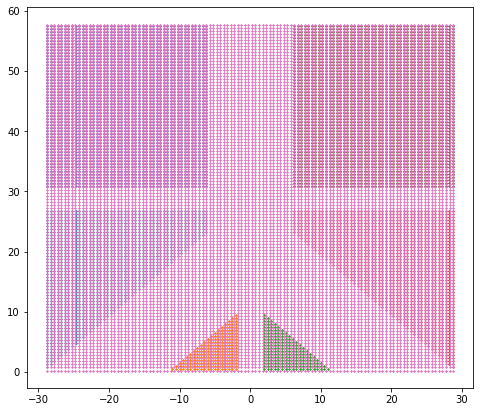

In [17]:
plt.figure(figsize = (8, 7))
for name, indices in voltage_regions.items():
    grid_to_plot = grid_points[indices][:, [0, 1]]
    plt.scatter(grid_to_plot[:, 0], grid_to_plot[:, 1], s = 0.5)
    
for i in range(len(acc_indices)):
    to_plot = grid_points[twodeg_grid[[acc_indices[i]]]]
    print(to_plot)
    plt.scatter(to_plot[0][0], to_plot[0][1]);

#### LU decomposition of finite system

In [18]:
%%time

linear_problem = linear_problem_instance(poisson_system)

CPU times: user 3.38 s, sys: 183 ms, total: 3.56 s
Wall time: 3.55 s


In [19]:
site_coords, site_indices = discrete_system_coordinates(
    poisson_system, [('charge', 'twoDEG')], boundaries=None
)

crds = site_coords[:, [0, 1]]
grid_spacing = grid_spacing_twoDEG
offset = crds[0]%grid_spacing

In [20]:
grid_points= poisson_system.grid.points

In [21]:
charge_regions = poisson_system.regions.charge.tag_points

In [22]:
voltage_regions = poisson_system.regions.voltage.tag_points
regions_to_add = []
for region in voltage_regions.keys():
    if region not in ['dirichlet_0', 'dirichlet_1', 'dirichlet_2', 'dirichlet_3']:
        regions_to_add.append(('voltage', region))
for region in charge_regions.keys():
    # if region not in ['air']:
    regions_to_add.append(('charge', region))

#### Verify the potential

In [23]:
voltage_regions = list(poisson_system.regions.voltage.tag_points.keys())

In [42]:
depleted = -1e-3
acumulate = 4e-3

def voltage_dict(depleted, acumulate, arm=None, arm_v=depleted-1e-3):
    voltages = {}

    voltages['left_1'] = depleted
    voltages['left_2'] = depleted

    voltages['right_1'] = depleted
    voltages['right_2'] = depleted

    voltages['top_1'] = depleted
    voltages['top_2'] = depleted

    voltages['global_accumul'] = acumulate
    
    if arm is not None:
        voltages[arm+'_1'] = arm_v
        voltages[arm+'_2'] = arm_v

    return voltages

In [43]:
voltages = voltage_dict(depleted, acumulate, arm='left')

In [44]:
%%time

charges = {}
clean_potential = gate_potential(
        poisson_system,
        linear_problem,
        site_coords[:, [0, 1]],
        site_indices,
        voltages,
        charges,
        offset=offset,
        grid_spacing=a
    )

CPU times: user 548 ms, sys: 3 ms, total: 551 ms
Wall time: 548 ms


In [45]:
coordinates = np.array(list(clean_potential.keys()))

x = coordinates[:, 0]
y = coordinates[:, 1]
width_plot = np.unique(x).shape[0]
X = x.reshape(width_plot, -1) / a
Y = y.reshape(width_plot, -1) / a
Z = np.round(np.array(list(clean_potential.values())).reshape(width_plot, -1) * -1, 4)

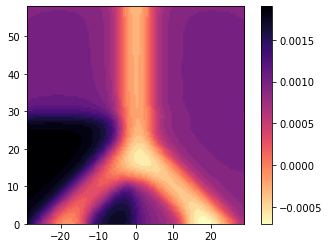

In [46]:
plt.figure()
plt.imshow(np.rot90(Z), extent = (xmin, xmax, ymin, ymax), cmap = 'magma_r')
plt.colorbar();

Text(0.5, 1.0, 'V(x,y) - V(-x,y)')

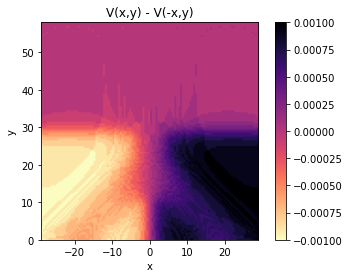

In [47]:
plt.imshow((np.rot90(Z[::-1,:])-np.rot90(Z)), extent = (xmin, xmax, ymin, ymax), cmap = 'magma_r')
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("V(x,y) - V(-x,y)")

#### Build kwant object

In [48]:
# Build kwant system

R_a = R*a
width_a = width*a
l = 150 * a
w = 7 * a
boundaries = [xmin, xmax, ymin, ymax, min(grid_points[:, 2]), max(grid_points[:, 2])]
boundaries = np.array(boundaries) * a

geometry ={'nw_l': l, 'nw_w': w,
           's_w': boundaries[1] - boundaries[0],
           's_l': boundaries[3] - boundaries[2],
           'centers':[[-R_a+width_a/np.sqrt(2), 0],
                      [-(-R_a+width_a/np.sqrt(2)), 0], 
                      [0,boundaries[3]+l-a]
                     ]
          }

In [49]:
%%time

trijunction, f_params = finite_system(**geometry)
trijunction = trijunction.finalized()

CPU times: user 283 ms, sys: 5.05 ms, total: 288 ms
Wall time: 284 ms


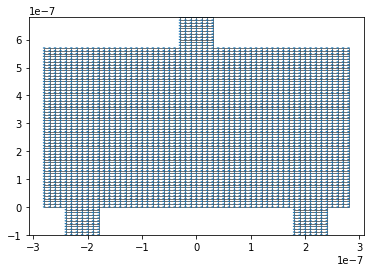

In [50]:
fig, ax = plt.subplots()
kwant.plot(trijunction, ax=ax, lead_site_size = 4)
ax.set_ylim(-10*a, boundaries[3]+10*a)
grid_points = poisson_system.grid.points
voltage_regions = poisson_system.regions.voltage.tag_points

# for name, indices in voltage_regions.items():
#     if name not in ['global_accumul']:
#         grid_to_plot = a*grid_points[indices][:, [0, 1]]
#         ax.scatter(grid_to_plot[:, 0], grid_to_plot[:, 1], s = 0.5)


In [51]:
import pickle

In [52]:
with open("/home/tinkerer/trijunction-design/data/optimal_phase.pkl", 'rb') as infile:
    optimal_phase = pickle.load(infile)

FileNotFoundError: [Errno 2] No such file or directory: '/home/tinkerer/trijunction-design/data/optimal_phase.pkl'

In [53]:
optimal_phase = optimal_phase * np.pi

NameError: name 'optimal_phase' is not defined

#### Optimal phases

In [64]:
def fixed_potential_solver(kwant_syst, base_params, eigenvecs=False, n=20):

    def solver(extra_params):

        system, f_params = kwant_system
        base_params.update(extra_params)
        ham_mat = system.hamiltonian_submatrix(sparse=True, params=f_params(**base_params))

        if eigenvecs:
            evals, evecs = sl.sort_eigen(sla.eigsh(ham_mat.tocsc(), k=n, sigma=0))
        else:
            evals = np.sort(
                sla.eigsh(ham_mat.tocsc(), k=n, sigma=0, return_eigenvectors=eigenvecs)
            )
            evecs = []

        return evals, evecs

    return solver

In [65]:
kwant_system = [trijunction, f_params]
params = pm.junction_parameters(m_nw=pm.bands[0]*np.ones(3))

In [66]:
arms = ['left', 'right', 'top']
potentials = []
depleted = -1.5e-3
acumulate = 4.5e-3
closed_arm = -5e-3

for arm in arms:
    voltages = voltage_dict(depleted, acumulate, arm=arm, arm_v=closed_arm)
    charges = {}
    potential = gate_potential(
            poisson_system,
            linear_problem,
            site_coords[:, [0, 1]],
            site_indices,
            voltages,
            charges,
            offset = offset[[0, 1]],
            grid_spacing = a
        )

    #potential.update((x, y*-1) for x, y in potential.items())
    potentials.append(potential)

In [67]:
phases = np.linspace(0, 2, 100) * np.pi

In [82]:
phis1 = [{'phi1': phi, 'phi2': 0} for phi in phases]
phis2 = [{'phi2': phi, 'phi1': 0} for phi in phases]
phis = [phis2, phis2, phis1]

In [84]:
params.update(potential=potential)
args_db = db.from_sequence(phis[i])

In [86]:
solver = fixed_potential_solver(kwant_system, params, eigenvecs=False)

In [135]:
topo_gap = solver(phis[0][0])[0][-1]

In [92]:
%%time
results = []
with Cluster(options) as cluster:

    cluster.scale(n=20)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])
    
    i = 0

    for potential in potentials:
        params.update(potential=potential)
        solver = fixed_potential_solver(kwant_system, params, eigenvecs=False)
        args_db = db.from_sequence(phis[i])
        result = args_db.map(solver).compute()

        i += 1

        energies = []
        for aux, _ in result:
            energies.append(aux)
        results.append(energies)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/5d4af2a475184ef89fa9916a189bbf96/status
CPU times: user 1min 8s, sys: 2.07 s, total: 1min 10s
Wall time: 2min 58s


In [182]:
max_phis_id = []
for pair in results:
    max_phis_id.append(tl.find_resonances(energies=np.array(pair), n=20, sign=-1, i=-1)[1])
max_phis_id = np.array(max_phis_id).flatten()
max_phis = phases[max_phis_id]/np.pi

In [183]:
max_phis

array([1.19191919, 0.82828283, 1.33333333])

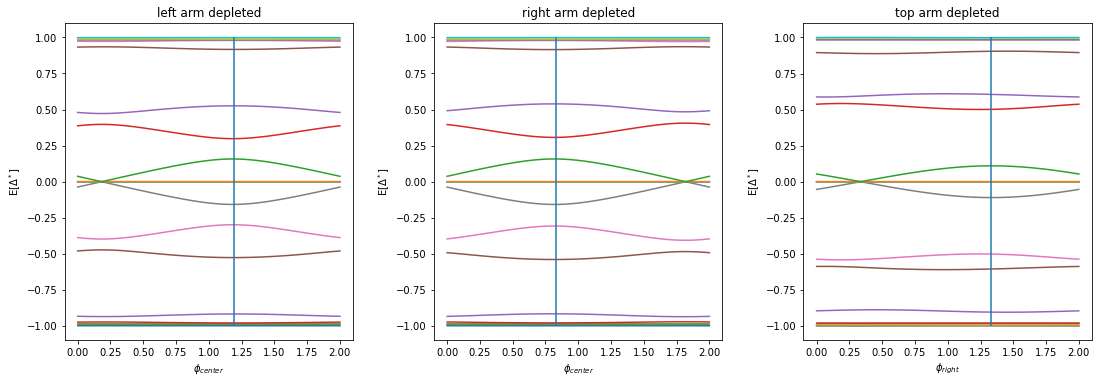

In [163]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
fig.tight_layout(w_pad=5)
i = 0
titles = ['left arm depleted', 'right arm depleted', 'top arm depleted']
phis_labels = [r'$\phi_{center}$', r'$\phi_{center}$', r'$\phi_{right}$']

peaks = []

for energies in results:
    energies = np.array(energies)
    for level in energies.T:
        ax[i].plot(phases/np.pi, level/topo_gap)
    ax[i].vlines(x=max_phis[i], ymin=-1, ymax=1)
    ax[i].set_title(titles[i])
    ax[i].set_ylabel(r'E[$\Delta^*]$')
    ax[i].set_xlabel(phis_labels[i])
    i += 1
    

#### Optimize gate voltages

In [282]:
from scipy import sparse

In [283]:
poisson_params = {
    'poisson_system': poisson_system,
    'linear_problem': linear_problem,
    'site_coords': site_coords,
    'site_indices': site_indices,
}    

crds = site_coords
grid_spacing = grid_spacing_twoDEG
offset = crds[0]%grid_spacing

kwant_params = {
    'offset': offset,
    'grid_spacing': a,
    'finite_system_object': trijunction,
    'finite_system_params_object': f_params,
    
}


In [284]:
def spectrum_f_voltages(
    kwant_params,
    general_params,
    potential,
    no_of_eigenvalues = 6,
    return_eigenvecs = False,
    phis = [0, 0],    
):
    kp = kwant_params
    
    general_params.update(potential=potential)
    

    general_params['phi1'] = phis[0]
    general_params['phi2'] = phis[1]
    
    ham_mat = kp['finite_system_object'].hamiltonian_submatrix(
        sparse=True, params=kp['finite_system_params_object'](**general_params))
    
    if return_eigenvecs:
        evals, evecs = sl.sort_eigen(sparse.linalg.eigsh(ham_mat.tocsc(), k=no_of_eigenvalues, sigma = 0))
        
        return evals, evecs
    else:
        evals = np.sort(
            sparse.linalg.eigsh(ham_mat.tocsc(), k = no_of_eigenvalues, sigma = 0,
                                return_eigenvectors = return_eigenvecs)
        )
        evecs = []
        
        return evals

In [285]:
voltage_dict = {'left' : -0.0026, 
                'right' : -0.0028, 
                'top' : -0.0024, 
                'back' : 0.00045}

In [286]:
for i in range(1, 3):
    voltages['left_'+str(i)] = voltage_dict['left']
    voltages['right_'+str(i)] = voltage_dict['right']
    voltages['top_'+str(i)] = voltage_dict['top']
    
voltages['global_accumul'] = voltage_dict['back']

In [287]:
centers = np.array(geometry['centers']) / a
nw_l = geometry['nw_l'] / a
nw_w = geometry['nw_w'] / a

depletion_regions  = {'left': np.array(((centers[0][0] - nw_w /2, centers[0][1]),
                              (centers[0][0] + nw_w /2, centers[0][1])), dtype = 'float32'),
                      'right': np.array(((centers[1][0] - nw_w /2, centers[1][1]),
                               (centers[1][0] + nw_w /2, centers[1][1])), dtype = 'float32'),
                     'top':   np.array(((centers[2][0] - nw_w /2, centers[2][1] - nw_l),
                              (centers[2][0] + nw_w /2, centers[2][1] - nw_l)), dtype = 'float32')}

In [288]:
grid = poisson_system.grid.points.astype('float32')

In [289]:
voltage_regions = poisson_system.regions.voltage.tag_points

In [290]:
twodeg_grid = site_indices
twodeg_grid_monolayer = twodeg_grid[grid[twodeg_grid][:, 2] == np.unique(grid[twodeg_grid][:, 2])[0]]

In [291]:
def depletion_points(grid, monolayer, boundary):
    Y = np.argmin(np.abs((grid[monolayer][:, 1] - boundary[0, 1])))
    X = grid[monolayer][:, 1] == grid[monolayer[Y]][1]
    point_indices = np.multiply(grid[monolayer[X]][:, 0] > boundary[0, 0], 
                                grid[monolayer[X]][:, 0] < boundary[1, 0])
    
    return monolayer[X][point_indices]

In [292]:
def closest_node(node, nodes):
    """Euclidean distance between a node and array of nodes"""
    nodes = np.asarray(nodes)
    dist = np.sum((nodes - node)**2, axis=1)
    return np.argmin(dist)

In [293]:
dep_indices = {}
acc_indices = {}
for gate in ['left_1', 'left_2', 'right_1', 'right_2', 'top_1', 'top_2']:
    indices = voltage_regions[gate]
    center = Polygon(grid_points[indices][:, [0, 1]]).centroid.coords
    closest_coord_index = closest_node(list(center)[0], 
                                       grid_points[twodeg_grid][:, [0, 1]])
    dep_indices[gate] = [closest_coord_index]

nw_centers = {}
nw_centers['left'] = np.array(geometry['centers'][0])/a
nw_centers['right'] = np.array(geometry['centers'][1])/a
nw_centers['top'] = np.array(geometry['centers'][2])
nw_centers['top'][1] -= l
nw_centers['top'][1] /= a

for gate in ['left']:
    closest_coord_index = closest_node(nw_centers[gate], grid_points[twodeg_grid][:, [0, 1]])
    dep_indices[gate] = [closest_coord_index]
    
for gate in ['right', 'top']:
    closest_coord_index = closest_node(nw_centers[gate], grid_points[twodeg_grid][:, [0, 1]])
    acc_indices[gate] = [closest_coord_index]

In [294]:
depletion = np.array([[dep_indices['right_1'], dep_indices['right_2']],
             [dep_indices['top_1'], dep_indices['top_2']],
             [dep_indices['left_1'], dep_indices['left_2']],
             ])

uniform = []

accumulation = [[acc_indices['right']], [acc_indices['top']]]

In [295]:
def left(site):
    x, y = site.pos
    return x < 0
leftop = Density(trijunction, onsite = np.eye(4), where = left, sum = True)

def right(site):
    x, y = site.pos
    return x > 0
rightop = Density(trijunction, onsite = np.eye(4), where = right, sum = True)

def top(site):
    x, y = site.pos
    return y > 0
topop = Density(trijunction, onsite = np.eye(4), where = top, sum = True)

In [296]:
from utility import gather_data

In [297]:
def gate_tuner(x, *argv):
    
    voltages = {}
    
    voltages['left_1'] = x[0]
    voltages['left_2'] = voltages['left_1']
    voltages['right_1'] = x[1]
    voltages['right_2'] = voltages['right_1']
    voltages['top_1'] = x[2]
    voltages['top_2'] = voltages['top_1']
    voltages['global_accumul'] = x[3]
    
    poisson_params, kwant_params, general_params,  = argv[:3]
    dep_points, acc_points, coupled_pair, uncoupled_pairs  = argv[3:7]
    base_hamiltonian, linear_hamiltonian = argv[7:9]
    mlwf = argv[9]
    uniform = argv[10]
    
    
    pp = poisson_params
    kp = kwant_params
    
    charges = {}
    potential = gate_potential(
            pp['poisson_system'],
            pp['linear_problem'],
            pp['site_coords'],
            pp['site_indices'],
            voltages,
            charges,
            offset = kp['offset'],
            grid_spacing = kp['grid_spacing']
        )
    
    potential.update((x, y*-1) for x, y in potential.items())
    
    
    potential_array = np.array(list(potential.values()))
    
    
    dep_acc_cost = []
    
    barrier_height = []
    
    for i, _ in enumerate(acc_points):
        dep_potential = potential_array[np.hstack(dep_points[i])]
        acc_potential = potential_array[acc_points[i]]
        
        if acc_potential > general_params['mus_nw'][0]:
            dep_acc_cost.append(np.abs(acc_potential - general_params['mus_nw'][0]))
            
        if np.any(dep_potential < acc_potential):
            dep_acc_cost.append(np.abs(dep_potential[np.where(dep_potential < acc_potential)] -\
                                           acc_potential))
            
        # barrier_height.append(sum(np.abs(dep_potential - acc_potential)))
    
    
    if len(dep_points) > len(acc_points):
        dep_potential = potential_array[np.hstack(dep_points[-1])]
        
        if np.any(dep_potential < general_params['mus_nw'][0]):
            dep_acc_cost.append(np.abs(dep_potential[np.where(dep_potential < general_params['mus_nw'][0])] -\
                                           general_params['mus_nw'][0]))
    
    coupling_cost = 0.0
    
    if len(dep_acc_cost):
        # print(dep_acc_cost)
        return sum(np.hstack(dep_acc_cost))
    else:
        uniformity = 0.0
        if len(uniform):
            uniformity = np.abs(potential_array[uniform[0]] - potential_array[uniform[1]])
        
        summed_ham = sum(
            [
                linear_ham[key] * voltages[key]
                for key, value in linear_ham.items()
            ]
        )

        tight_binding_hamiltonian = base_hamiltonian + summed_ham


        eigval, eigvec = sl.sort_eigen(sparse.linalg.eigsh(tight_binding_hamiltonian.tocsc(), 
                                                           k=6, sigma = 0))

#         fig, ax = plt.subplots(1, 6, figsize = (10, 5), sharey= True)
#         for i in range(6):
#             kwant.plotter.density(trijunction, density(eigvec[i]), ax = ax[i]);

#         filepath = '/home/tinkerer/trijunction-design/data/optimization/'
#         seed = gather_data(filepath)

#         if ".ipynb_checkpoints" in seed:
#             os.system("rm -rf .ipynb_checkpoints")

#         if len(seed):
#             file_name = filepath + "plt_" + str(max(seed) + 1) + "_.png"
#         else:
#             file_name = filepath + "plt_" + str(0) + "_.png"

#         plt.savefig(file_name, format="png", bbox_inches="tight", pad_inches=0.0)

#         plt.close()



        lowest_e_indices = np.argsort(np.abs(eigval))[: 6]
        lowest_e_energies = eigval[lowest_e_indices]
        coupled_states = eigvec.T[:, lowest_e_indices].T

        # Overlap matrix
        decoupled_states = mlwf
        S = coupled_states @ decoupled_states.T.conj()

        # Unitary matrix using SVD
        U, _, Vh = svd(S)
        S_prime = U @ Vh

        # Transform coupled Hamiltonian to Majorana basis
        coupled_ham = S_prime.T.conj() @ np.diag(lowest_e_energies) @ S_prime

        coupled_ham = coupled_ham[2:5, 2:5]/general_params['Delta']

        print(coupled_ham[coupled_pair[0], coupled_pair[1]])


        coupled_cost = np.abs(coupled_ham[coupled_pair[0], coupled_pair[1]])


        uncoupled_cost = (np.abs(coupled_ham[uncoupled_pairs[0][0], uncoupled_pairs[0][1]]) +
                          np.abs(coupled_ham[uncoupled_pairs[1][0], uncoupled_pairs[1][1]]))
        
        
        
        return (-1 * coupled_cost) + uncoupled_cost + uniformity

In [298]:
mu = pm.bands[0]

In [299]:
coupled_pairs = [1, 2] # 0: left, 1: right, 2: top
uncoupled_pairs = [[0, 1], [0, 2]]
args = (poisson_params, kwant_params, params, 
        depletion, accumulation, coupled_pairs, uncoupled_pairs,
        base_hamiltonian, linear_ham,
        mlwf, uniform)

In [300]:
initial_condition = [ -0.0037, -0.0014,  -0.0014, 3e-3]

In [301]:
%%time

sol1 = minimize(
            gate_tuner,
            initial_condition,
            args=args,
            # ftol = 1e-3,
            # verbose = 2,
            # max_nfev= 15
    # bounds = bounds,
    method = 'trust-constr',
            options = {'disp': True, 'verbose': 2,
                      'initial_tr_radius': 1e-3, 'gtol': 1e0}
        )

(0.018204615124820845+6.170969118006415e-05j)
(0.01820445593462821+6.170915155951993e-05j)
(0.018203937177749943+6.170739308677874e-05j)
(0.01820420474413761+6.170830007901865e-05j)
(0.018204948552317902+6.17108214271214e-05j)
| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   5   |   0   | -1.8023e-02 | 1.00e-03 | 4.51e+01 | 0.00e+00 |
(-0.05402974742351469-0.00018314910728875982j)
(-0.05402972783296339-0.00018314904088111947j)
(-0.05402900735905715-0.0001831465986305447j)
(-0.054032071898107686-0.00018315698675161452j)
(-0.054029804069949824-0.00018314929930754093j)
|   2   |  10   |   1   | -5.3893e-02 | 2.00e-03 | 1.46e+02 | 0.00e+00 |
(-0.04738871255727249-0.0001606374388600648j)
(-0.04738894785791046-0.00016063823647841988j)
(-0.047391587316939106-0.00016064718367130978j)
(-0.04738970189354516-0.00016064079249569166j)
(-0.04738838382411653-0.00016063632452589972j)
|   3   | 

In [302]:
optimal_phase

NameError: name 'optimal_phase' is not defined

In [ ]:
%%time

base_hamiltonian, linear_ham = linear_Hamiltonian(poisson_params, 
                                                  kwant_params, 
                                                  params, 
                                                  list(voltage_regions.keys()),
                                                  phis = [0, max_phis[2]])

In [303]:
density = Density(trijunction, np.eye(4))

#### Algorithm to transform basis of the coupled Hamiltonian to Majorana Hamiltonian

### 1. Simulate the decoupled system and Wannerize the eigenstates

In [217]:
# 1. Simulate the decoupled system and Wannerize the eigenstates

voltages = {'left_1': -0.0036,
            'left_2': -0.0086,
            'right_1': -0.0086,
            'right_2': -0.0036,
            'top_1': -0.0037,
            'top_2': -0.0037,
            'global_accumul': -7e-05}

summed_ham = sum(
    [
        linear_ham[key] * voltages[key]
        for key, value in linear_ham.items()
    ]
)

tight_binding_hamiltonian = base_hamiltonian + summed_ham


eigval, eigvec = sl.sort_eigen(sparse.linalg.eigsh(tight_binding_hamiltonian.tocsc(), 
                                                   k=12, sigma = 0))

lowest_e_indices = np.argsort(np.abs(eigval))[: 6]
lowest_e_energies = eigval[lowest_e_indices]
lowest_e_states = eigvec.T[:, lowest_e_indices].T

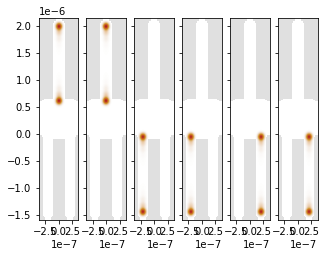

In [218]:
fig, ax = plt.subplots(1, len(lowest_e_states), figsize = (5, 5), sharey = True)
for i in range(len(lowest_e_states)):
    cax = kwant.plotter.density(trijunction, density(lowest_e_states[i]), ax = ax[i]);

#### Wannierization

In [219]:
X_operator = Density(
            trijunction, onsite=lambda site: np.eye(4) * site.pos[0]
        )

Y_operator = Density(
            trijunction, onsite=lambda site: np.eye(4) * site.pos[1]
        )

In [220]:
projected_X_operator = wannier_1D_operator(X_operator, 
                                           lowest_e_states.T)

projected_Y_operator = wannier_1D_operator(Y_operator, 
                                           lowest_e_states.T)

In [221]:
w_basis = wannier_basis([projected_X_operator, 
                         projected_Y_operator])

mlwf = w_basis.T @ lowest_e_states

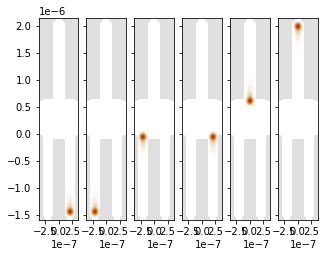

In [222]:
fig, ax = plt.subplots(1, 6, figsize = (5, 5), sharey = True)
for i in range(6):
    cax = kwant.plotter.density(trijunction, density(mlwf[i]), ax = ax[i]);

### 2. Simulate coupled system and find the eigenstates

In [264]:
voltages = {'left_1': -0.0014,
 'left_2': -0.0014,
 'right_1': -0.0037,
 'right_2': -0.0037,
 'top_1': -0.0014 ,
 'top_2': -0.0014,
 'global_accumul': 3e-3}

In [308]:
sol1.x

array([-0.02139896, -0.00301283, -0.00502079,  0.02511067])

In [309]:
x = sol1.x

voltages = {}
    
voltages['left_1'] = x[0]
voltages['left_2'] = voltages['left_1']
voltages['right_1'] = x[1]
voltages['right_2'] = voltages['right_1']
voltages['top_1'] = x[2]
voltages['top_2'] = voltages['top_1']
voltages['global_accumul'] = x[3]

with open("/home/tinkerer/trijunction-design/data/LC_voltages.pkl", 'wb') as infile:
    pickle.dump(voltages, infile)

In [233]:
potential = gate_potential(
        poisson_system,
        linear_problem,
        site_coords[:, [0, 1]],
        site_indices,
        voltages,
        charges,
        offset = offset[[0, 1]],
        grid_spacing = kwant_params['grid_spacing']
    )

potential.update((x, y*-1) for x, y in potential.items())

params.update(potential=potential)

In [234]:
f_mu = f_params(**params)['mu']

In [235]:
def plot_f_mu(i):
    x, y = trijunction.sites[i].pos
    return f_mu(x, y)

In [236]:
kwant_sites = np.array(list(site.pos for site in trijunction.sites))

In [237]:
to_plot = [plot_f_mu(i) for i in range(len(kwant_sites))]

In [238]:
grid_points = poisson_system.grid.points
voltage_regions = poisson_system.regions.voltage.tag_points

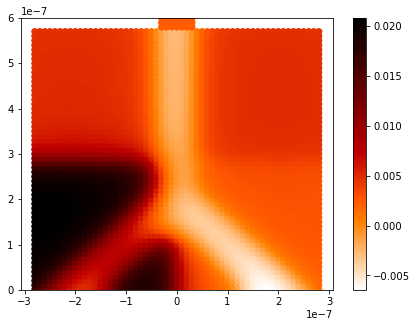

In [239]:
fig, ax = plt.subplots(1, 1, figsize = (7, 5))
cax = ax.scatter(kwant_sites[:, 0 ], kwant_sites[:, 1], 
                 c = np.array(to_plot), cmap = 'gist_heat_r'
                );
ax.set_ylim(0, 0.6e-6);
plt.colorbar(cax);
# plt.axis('equal')

In [265]:
summed_ham = sum(
    [
        linear_ham[key] * voltages[key]
        for key, value in linear_ham.items()
    ]
)

tight_binding_hamiltonian = base_hamiltonian + summed_ham


eigval, eigvec = sl.sort_eigen(sparse.linalg.eigsh(tight_binding_hamiltonian.tocsc(), 
                                                   k=6, sigma = 0))

In [305]:
lowest_e_indices = np.argsort(np.abs(eigval))[: 6]
lowest_e_energies = eigval[lowest_e_indices]
coupled_states = eigvec.T[:, lowest_e_indices].T

In [324]:
lowest_e_energies/topo_gap

array([-1.31169235e-06,  1.31169235e-06, -1.44333377e-04,  1.44333377e-04,
       -2.79610138e-01,  2.79610138e-01])

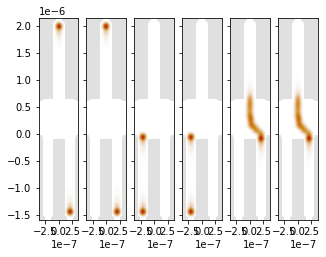

In [325]:
fig, ax = plt.subplots(1, len(lowest_e_states), figsize = (5, 5), sharey = True)
for i in range(len(lowest_e_states)):
    cax = kwant.plotter.density(trijunction, density(coupled_states[i]), ax = ax[i]);

In [269]:
# Overlap matrix
decoupled_states = mlwf
S = coupled_states @ decoupled_states.T.conj()

# Unitary matrix using SVD
U, _, Vh = svd(S)
S_prime = U @ Vh

# Transform coupled Hamiltonian to Majorana basis
coupled_ham = S_prime.T.conj() @ np.diag(lowest_e_energies) @ S_prime

ModuleNotFoundError: No module named 'Matrix'

In [245]:
Matrix(np.round(coupled_ham[2:5, 2:5]/params['Delta'], 10))

NameError: name 'Matrix' is not defined

In [ ]:
Matrix(np.round(coupled_ham[2:5, 2:5], 10))

In [246]:
 Matrix(coupled_ham[2:5, 2:5])

NameError: name 'Matrix' is not defined

#### Linear part of the Hamiltonian

In [271]:
from tqdm import tqdm

In [272]:
def linear_Hamiltonian(
    poisson_params,
    kwant_params,
    general_params,
    gates,
    phis = [0.0, 0.0]
):

    ## non-linear part of the Hamiltonian
    
    voltages = {}
    
    for gate in gates: voltages[gate] = 0.0
    
    kp = kwant_params
    pp = poisson_params
    
    charges = {}
    potential = gate_potential(
            pp['poisson_system'],
            pp['linear_problem'],
            pp['site_coords'][:, [0, 1]],
            pp['site_indices'],
            voltages,
            charges,
            offset = kp['offset'][[0, 1]],
            grid_spacing = kp['grid_spacing']
        )
    
    
    
    general_params.update(potential=potential)
    general_params['phi1'] = phis[0]
    general_params['phi2'] = phis[1]
    
    bare_hamiltonian = kp['finite_system_object'].hamiltonian_submatrix(
        sparse=True, params=kp['finite_system_params_object'](**general_params))
    
    
    hamiltonian_V = {}
    for gate in tqdm(gates):
        

        voltages_t = dict.fromkeys(voltages, 0.0)

        voltages_t[gate] = 1.0

        potential = gate_potential(
            pp['poisson_system'],
            pp['linear_problem'],
            pp['site_coords'][:, [0, 1]],
            pp['site_indices'],
            voltages_t,
            charges,
            offset = kp['offset'][[0, 1]],
            grid_spacing = kp['grid_spacing']
        )
    

        general_params.update(potential=potential)

        hamiltonian = kp['finite_system_object'].hamiltonian_submatrix(
            sparse=True, params=kp['finite_system_params_object'](**general_params))


        hamiltonian_V[gate] = hamiltonian - bare_hamiltonian

    return bare_hamiltonian, hamiltonian_V


In [273]:
summed_ham = sum(
        [
            linear_ham[key] * voltages[key]
            for key, value in linear_ham.items()
        ]
    )


In [274]:
pp = poisson_params
kp = kwant_params
potential = gate_potential(
    pp['poisson_system'],
    pp['linear_problem'],
    pp['site_coords'][:, [0, 1]],
    pp['site_indices'],
    voltages,
    charges,
    offset = kp['offset'][[0, 1]],
    grid_spacing = kp['grid_spacing']
)


params.update(potential=potential)

test_hamiltonian = kp['finite_system_object'].hamiltonian_submatrix(
    sparse=True, params=kp['finite_system_params_object'](**params))

In [275]:
potential = gate_potential(
    pp['poisson_system'],
    pp['linear_problem'],
    pp['site_coords'],
    pp['site_indices'],
    voltages,
    charges,
    offset = kp['offset'],
    grid_spacing = kp['grid_spacing']
)


In [276]:
potential = gate_potential(
    pp['poisson_system'],
    pp['linear_problem'],
    pp['site_coords'][:, [0, 1]],
    pp['site_indices'],
    voltages,
    charges,
    offset = kp['offset'][[0, 1]],
    grid_spacing = kp['grid_spacing']
)

In [277]:
np.unique(grid_points[poisson_system.regions.charge.tag_points['twoDEG']][:, 2])

array([-0.5,  0. ,  0.5])

In [278]:
site_tuples = map(tuple, site_coords[:, [0, 1]])

In [279]:
from potential import _linear_solution
solution = _linear_solution(poisson_system, linear_problem, voltages, {})

potential = solution[site_indices]

In [280]:
potential_dict = {}
for i, site_tuple in enumerate(site_tuples):
    if grid_spacing == 1:
        potential_dict[ta.array((site_tuple-offset))] = potential[i]
    else:
        potential_dict[ta.array((site_tuple-offset)*kp['grid_spacing'])] = potential[i]

NameError: name 'ta' is not defined

In [281]:
len(potential_dict)

0